## Introduction to the HZ_evolution package

This jupyter notebook is intended to provide an introduction to the features of the HZ_evolution package. The purpose of this package is to characterize the instellation history of exoplanets, model how a star's habitable zone changes in time, and to calculate the duration that a planet spends in the habitable zone.

Before running this notebook it is recommended that you make sure that the ```isochrones``` package is working properly. We recommend running through their [Quick Start guide](https://isochrones.readthedocs.io/en/latest/quickstart.html) up until the section on model fitting.

First let's start by importing some packages that we will use in this example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Then we will import the ```HZ_evolution``` package itself and call it ```hz```

In [2]:
import HZ_evolution as hz

PyMultiNest not imported.  MultiNest fits will not work.


(Don't worry if you get a warning messages about PyMultiNest or Holoviews if you don't have it installed)

Most of the functions in HZ_evolution package are contained within two main object classes: the ```HZ_evolution``` object which describes how a star's habitable zone evolves in time, and the ```HZ_planet``` object which is a subclass of ```HZ_evolution``` which calculate's a planets instellation history, duration spend in the habitable zone, and durations spent interior or exterior to the habitable zone before entering.

These objects require inputs for a star's evolutionary track in the form of numpy arrays for ```age``` (in yrs),```L``` (in L_sun), and ```Teff``` (in K). These can be from any user supplied model, or one can generate them from a model grid. In this example we will use the MIST isochrone grid, but the functions are flexible enough to use any model input in this form.

First we will import the ```isochrones```package and import the grid of MIST evolutionary tracks

In [3]:
from isochrones.mist import MIST_EvolutionTrack
mist_track = MIST_EvolutionTrack()


Next we will specify the star that we want to similate.  For this case we will use a solar analog. Note that MIST uses EEP (equivalent evolutionary phase as a proxy for age)

In [1]:
mass_0 = 1.0
feh_0 = 0.0
eep_0= 355 #corresponding to age= 4.58e9 yrs

pars= [mass_0, eep_0, feh_0]

We will use a shortcut function in HZ_evolution to generated an interpolated evolutionary track between MIST grid points (Note that for the case of this specific example, the values fall right on one of the MIST grid points so we could instead take a slice of the dataframe, but this won't be an option for your average field star)

In [5]:
track_df= hz.generate_interpolated_evol_track(pars,mist_track=mist_track)
age_input= 10**track_df['age'].values #MIST gives log(age), convert to age
L_input= 10**track_df['logL'].values #MIST gives log(L), convert to L
Teff_input= track_df['Teff'].values

If this is your first time running the ```isochrones``` package, it will take a while to run while it downloads the MIST isochrones and interpolates over them. After the first time you access the MIST grid, it is very quick to evaluate on the order of 10 ms.

## The HZ_evolution class
Next let's initialize an ```HZ_evolution``` object with this evolutionary track. We will specify the formulation of the habitable zone using the ```HZ_form``` keyword argument. The options for ```HZ_form``` are the Kopparapu+ 2013 moist greenhouse and max greenhouse ("K13"), Kopparapu+  2013 recent Venus and Early Mars ("K13_optimistic"), Ramire+z 2018 ("R18". One can also use a custom formulation of the habitable zone, providing functions for the inner and outer edges as keyword arguments. 

For our example lets use the Kopparapu+ 2013 optimistic habitable zone)

In [6]:
evol= hz.HZ_evolution(age_input,L_input,Teff_input, HZ_form="K13_optimistic")

Next lets use the ```HZ_evolution``` object to find the location of the continuously habitable zone (CHZ). There are multiple different definitions of the CHZ that one can specify. One can use the form of the CHZ that is often used where one considers regions that spend more than a fixed duration in the habitable zone to be continuously habitable. Alternatively, one can define the CHZ as the region around a star where planets sustain habitable conditions from a specified starting age to the current day.

As an example we shall simulate both cases: a fixed duration CHZ including planets that spend more than 2Gyr in the HZ and a sustained CHZ including planets that remain in the HZ from a starting age of 50 Myr to present.

These function will save the CHZ boundaries as attributes of ```evol``` which can be retreived later.

In [7]:
evol.get_fixed_age_CHZ(fixed_age=2e9)
evol.get_sustained_CHZ(CHZ_start_age=5e7)

print("Current HZ: %.3f  to %.3f (AU)"% (evol.current_i,evol.current_o))
print("Sustained CHZ: %.3f  to %.3f (AU)"% (evol.sCHZ_i, evol.sCHZ_o))
print("2Gyr fixed duration CHZ: %.3f  to %.3f (AU)"% (evol.fCHZ_i,evol.fCHZ_o))

Current HZ: 0.787  to 1.848 (AU)
Sustained CHZ: 0.787  to 1.538 (AU)
2Gyr fixed duration CHZ: 0.787  to 1.703 (AU)


We can see that the 2Gyr CHZ is wider than the sustained CHZ. This implies that some regions of the 2Gyr CHZ were originally outside of the habitable zone but entered it at a later date due to the star's evolution. We refer to planets that enter the HZ from outside as "Belatedly Habitable Planets".

To characterize the evolutionary history of planets in the habitable zone the ```HZ_evolution``` object includes functions to calculate the duration spent in the habitable zone, $\tau$, the duration spent interior to the habitable zone, $t_{int}$, and the duration spent exterior to the habitable zone, $t_{ext}$.

Let's calculate these quantities for a range of hypothetical planets spanning the current day habitable zone.

In [8]:
d_arr= np.linspace(0.95*evol.current_i,1.05*evol.current_o,500)

tau_arr= evol.obj_calc_tau(d_arr)
t_int_arr=evol.obj_calc_t_interior(d_arr)
t_ext_arr=evol.obj_calc_t_exterior(d_arr)

Now lets plot the results stored in the HZ_evolution object. First lets see how the HZ evolves in time

(100000.0, 4800000000.0)

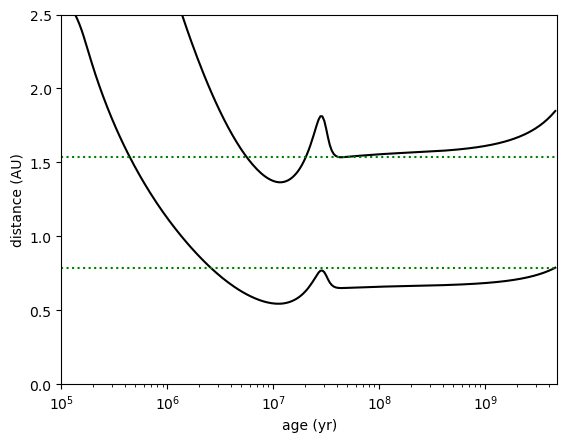

In [9]:
hz_fig, hz_ax = evol.plot_HZ(include_sCHZ=True)
hz_ax.set_ylim([0,2.5])
hz_ax.set_xlim([1e5,4.8e9])

The green dotted lines here represent the sustained CHZ, the region that remains in the HZ from t=5e7 yrs to present. 

Next lets plot the habitable duration $\tau$ for the array of planets spanning the HZ we calculated earlier

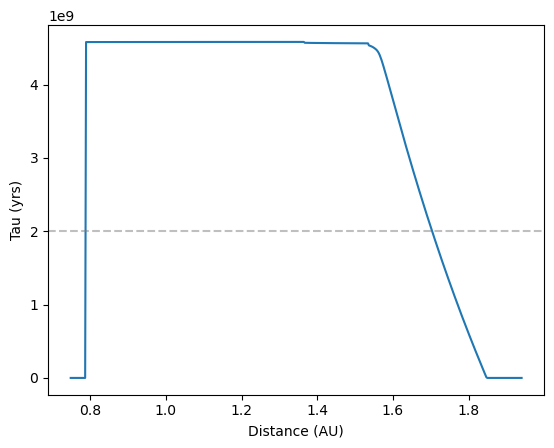

In [10]:
tau_fig, tau_ax = plt.subplots()
tau_ax.plot(d_arr, tau_arr)
tau_ax.set_xlabel("Distance (AU)")
tau_ax.set_ylabel("Tau (yrs)")
tau_ax.axhline(y=2e9,ls='--',color='grey',alpha=0.5)

One can recover the 2Gyr fixed age CHZ by finding where this curve intersects with $\tau$= 2 Gyr (shown as a grey dashed line)

Let's also plot the duration that planets currently in the habitable zone have spent interior to the HZ before entering it:

Text(0, 0.5, 't_int (yr)')

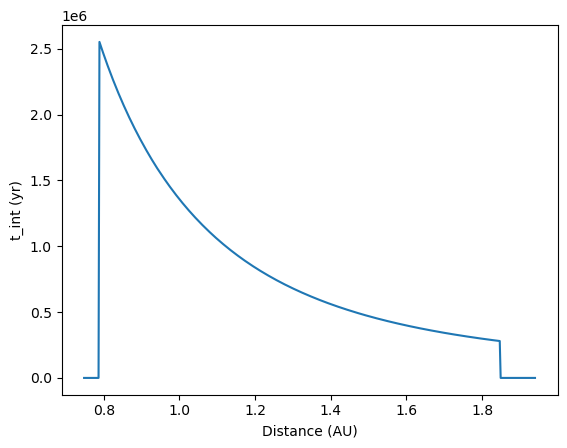

In [11]:
tint_fig, tint_ax=plt.subplots()
tint_ax.plot(d_arr,t_int_arr)
tint_ax.set_xlabel("Distance (AU)")
tint_ax.set_ylabel("t_int (yr)")

In this plot we see that the hypothetical planets at these distances only spend on the order a million yrs interior to the HZ. Given that on the premain sequence the star dimmed and the habitable zone moved inwards, the shape of this plot makes sense. Note that $t_{int}$ is zero outside the HZ, as you can have spent time outside the HZ prior to entering it if you never enter the HZ to begin with.

Next lets look at $t_{ext}$ the time spent exterior to the HZ before entering it:

Text(0, 0.5, 't_ext (yr)')

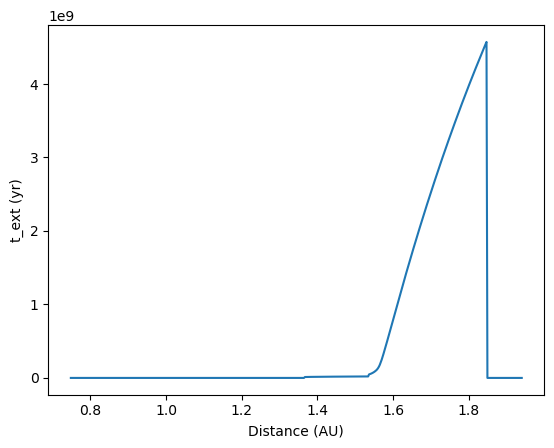

In [12]:
text_fig, text_ax= plt.subplots()
text_ax.plot(d_arr,t_ext_arr)
text_ax.set_xlabel("Distance (AU)")
text_ax.set_ylabel("t_ext (yr)")

In this plot we can see that planets near the outer edge of the HZ can spend billions of years outside the habitable zone before entering it. This is due to the star's gradual increase in luminosity on the main sequence, causing the HZ to move outwards.

## Application to Specific Planets

So far we have focused on modelling the habitable zone evolution of a given star. We could use the functions in the ```HZ_evolution``` to calculate the instellation history and habitable duration of a given planet, but it may be a bit cumbersome. To streamline the process one can use the ```HZ_planet``` object which is a sub class of ```HZ_evolution```.

An ```HZ_planet``` can be initialized in the same way as an ```HZ_evolution``` object, but with the addition of the semimajor axis of a specified planet. Alternatively one can specify an orbital period and stellar mass, so that it can compute the semimajor axis from Kepler's 3rd law.

Let's simulate an Earth-like planet at 1 AU

In [13]:
dist_input= 1.00

planet1= hz.HZ_planet(age_input, L_input, Teff_input,
                      Dist=dist_input,
                      HZ_form="K13_optimistic")

HZ_planet inherits all the attributes of ```HZ_evolution```, but also includes several planet specific attributes. We can calculate the habitable duration and times spent interior or exterior to the HZ using the ```get_tau```, ```get_t_int```, and ```get_t_ext``` functions

In [14]:
tau1= planet1.get_tau()
t_int1=planet1.get_t_int()
t_ext1=planet1.get_t_ext()

print("Habitable Duration: %.3e yrs"% tau1)
print("Time interior: %.3e yrs"% t_int1)
print("Time exterior: %.3e yrs"% t_ext1)

Habitable Duration: 4.580e+09 yrs
Time interior: 1.358e+06 yrs
Time exterior: 0.000e+00 yrs


It also stores the planet's instellation history which can be accessed as ```Seff```

Text(0, 0.5, 'S (S_Earth)')

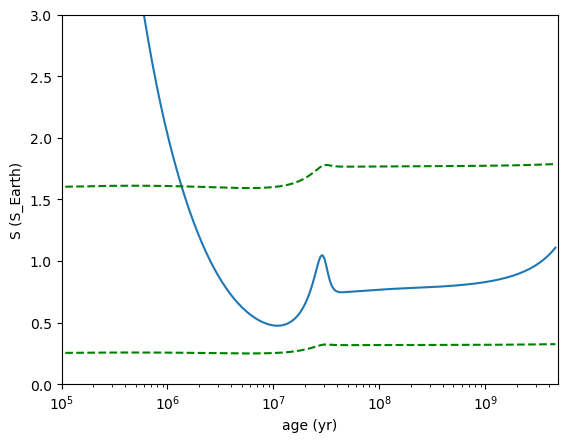

In [15]:
S_arr=planet1.Seff
HZ_i_arr= planet1.S_inner
HZ_o_arr= planet1.S_outer

S_fig,S_ax= plt.subplots()
S_ax.plot(planet1.age,S_arr)
S_ax.plot(planet1.age,HZ_i_arr,ls='--',color='green')
S_ax.plot(planet1.age,HZ_o_arr,ls='--',color='green')
S_ax.set_ylim([0,3.0])
S_ax.set_xlim([1e5,4.8e9])
S_ax.set_xscale("log")

S_ax.set_xlabel("age (yr)")
S_ax.set_ylabel("S (S_Earth)")

Here the green dashed lines show the habitable zone flux boundaries.

## $\tau$ interpolation

Beyond using the HZ_evolution and HZ_planet objects, this package also provides the ability to generate a model grid of habitable durations, time interior, and time exterior.  This is useful for stellar model fitting, where we would like to obtain these properties with uncertainties. Using interpolation, we can obtain these quantities at each step in an MCMC chain, without having to calculate them using a stellar evolutionary track. 

The ```HZ_evolution``` package includes utilities to calculate habitable durations for each point in the MIST isochrone grid. We use the ```DFInterpolator``` object in the ```isochrones.py``` package to obtain values of habitable durations for any set of stellar parameters ([Fe/H], initial mass, and equivalent evolutionary phase (EEP)), with planetary instellation $S_{eff}$ as an additional parameter

Constructing a 4D model grid for habitable duration is somewhat computer memory intensive and requires a decent amount of disc space. We include two options: one can run the full 4D model grid using the ```calculate_grid_4D``` function, or one can reduce the number of dimensions for the model grid and compute it at a fixed value of metallicity using the ```calculate_grid_3D``` function. The 3D option is less resource intensive and faster, but we recommend the using the 4D option if you are able.

These functions should be run before constructing an interpolator for habitable durations.  These functions take a decent amount of time to run and require a certain amount of disc space for their file outputs. In previous benchmarks ```calculate_grid_4D``` took 5054 s to run and required 3.5 GB of disk space. ```calculate_grid_3D``` took 827s and required 589MB.

In this example we will construct the model grid using the ```calculate_grid_4D``` function. It has optional keyword arguments to specify options such as the output file name and habitable zone formulation but we will use the default options for this example.

**The following step may take more than an hour of computation time depending on your computer, so make sure that you have time to leave it running in the background before running it.**

It only needs to be run once and then one will be able to access the model grid resulting from this calculation.

In [16]:
hz.calculate_grid_4D()

Beginning construction of 4D habitable duration grid.
[Fe/H] = -2.00 

Mass=0.10 

Mass=0.15 

Mass=0.20 

Mass=0.25 

Mass=0.30 

Mass=0.31 

Mass=0.32 

Mass=0.33 

Mass=0.34 

Mass=0.35 

Mass=0.36 

Mass=0.37 

Mass=0.38 

Mass=0.39 

Mass=0.40 

Mass=0.45 

Mass=0.50 

Mass=0.55 

Mass=0.60 

Mass=0.65 

Mass=0.70 

Mass=0.75 

Mass=0.80 

Mass=0.85 

Mass=0.90 

Mass=0.92 

Mass=0.94 

Mass=0.96 

Mass=0.98 

Mass=1.00 

Mass=1.02 

Mass=1.04 

Mass=1.06 

Mass=1.08 

Mass=1.10 

Mass=1.12 

Mass=1.14 

Mass=1.16 

Mass=1.18 

Mass=1.20 

Mass=1.22 

Mass=1.24 

Mass=1.26 

Mass=1.28 

Mass=1.30 

Mass=1.32 

Mass=1.34 

Mass=1.36 

Mass=1.38 

Mass=1.40 

Mass=1.42 

Mass=1.44 

Mass=1.46 

Mass=1.48 

Mass=1.50 



/Users/ntuchow/opt/anaconda3/envs/making_package/lib/python3.11/site-packages/HZ_evolution/hz_utils.py:70: RuntimeWarning: invalid value encountered in sqrt
  d= np.sqrt(L/Seff) #AU


Mass=1.52 

Mass=1.54 

Mass=1.56 

Mass=1.58 

Mass=1.60 

Mass=1.62 

Mass=1.64 

Mass=1.66 

Mass=1.68 

Mass=1.70 

Mass=1.72 

Mass=1.74 

Mass=1.76 

Mass=1.78 

Mass=1.80 

Mass=1.82 

Mass=1.84 

Mass=1.86 

Mass=1.88 

Mass=1.90 

Mass=1.92 

Mass=1.94 

Mass=1.96 

Mass=1.98 

Mass=2.00 

[Fe/H] = -1.75 

Mass=0.10 

Mass=0.15 

Mass=0.20 

Mass=0.25 

Mass=0.30 

Mass=0.31 

Mass=0.32 

Mass=0.33 

Mass=0.34 

Mass=0.35 

Mass=0.36 

Mass=0.37 

Mass=0.38 

Mass=0.39 

Mass=0.40 

Mass=0.45 

Mass=0.50 

Mass=0.55 

Mass=0.60 

Mass=0.65 

Mass=0.70 

Mass=0.75 

Mass=0.80 

Mass=0.85 

Mass=0.90 

Mass=0.92 

Mass=0.94 

Mass=0.96 

Mass=0.98 

Mass=1.00 

Mass=1.02 

Mass=1.04 

Mass=1.06 

Mass=1.08 

Mass=1.10 

Mass=1.12 

Mass=1.14 

Mass=1.16 

Mass=1.18 

Mass=1.20 

Mass=1.22 

Mass=1.24 

Mass=1.26 

Mass=1.28 

Mass=1.30 

Mass=1.32 

Mass=1.34 

Mass=1.36 

Mass=1.38 

Mass=1.40 

Mass=1.42 

Mass=1.44 

Mass=1.46 

Mass=1.48 

Mass=1.50 

Mass=1.52 

Mass=1.54 


This will take a while to run. Once it is finished we can use its output to construct an interpolator. The HZ_evolution package has two functions to construct an interpolator for a calculated model grid ```construct_interpolator_3D``` and ```construct_interpolator_4D``` corresponding to ```calculate_grid_3D``` and ```calculate_grid_4D``` respectively.

In our example we will use the ```construct_interpolator_4D``` function to make an interpolator for the 4 dimensional model grid we constructed in the previous step. While one could call the function without arguments in the form ```construct_interpolator_4D()``` to construct an interpolator using all the points in the model grid, it would be very RAM intensive and time consuming. In this example we will instead use keyword arguments to specify the region of parameter space we would like to interpolate over. We'll consider the region of parameter space around our solar model with masses within 0.3 Msun of the sun, [Fe/H] values within 0.5 dex, and EEPs (equivalent evolutionary phases) on the Main Sequence.



In [16]:
interp_func= hz.construct_interpolator_4D(feh_min=-0.5,feh_max=0.5,mass_min= 0.7,mass_max= 1.3,
                           eep_min=200,eep_max=450,Seff_min=0.1,Seff_max=2.1)

It may take a few seconds to a minute to construct the interpolator.


The ```interp_func``` is an ```isochrones.py``` ```DFinterpolator``` object which takes two arguments: an array of parameters and an array of property names to interpolate over. The input parameters for the interpolator are in the form:

pars= [initial [Fe/H],initial stellar mass, EEP, $S_{eff}$]

The names of the output properties $\tau$, $t_{interior}$, and $t_{exterior}$ are ```"tau"```, ```"t_int"```,```"t_ext"``` respectively.

Here are a few examples for how to call the interpolator:

Take for example a planet at Earth instellation around an early main sequence star with mass 0.75 Msun. We can calculate its habitable duration using:

In [22]:
pars=[0.0, 0.75, 300, 1.0]
tau_arr=interp_func(pars,['tau'])
print('Tau = %.3e yrs'% tau_arr[0])

Tau = 2.041e+09 yrs


Lets calculate time spent interior and time exterior to the HZ for this same planet:

In [24]:
tau_arr=interp_func(pars,['t_int','t_ext'])
print('t_int = %.3e yrs'% tau_arr[0])
print('t_ext = %.3e yrs'% tau_arr[1])

t_int = 5.743e+06 yrs
t_ext = 0.000e+00 yrs


Lets try an arbitrary new set of parameters:


In [30]:
pars=[0.266, 1.11, 401.7, 0.51]
tau_arr=interp_func(pars,['tau'])
print('Tau = %.3e yrs'% tau_arr[0])

Tau = 5.094e+09 yrs


Running the interpolator without specifying the output properties defaults to giving them all in the following order 'tau', 't_int', and  't_ext'

In [31]:
tau_arr=interp_func(pars)
print('Tau = %.3e yrs'% tau_arr[0])
print('t_int = %.3e yrs'% tau_arr[1])
print('t_ext = %.3e yrs'% tau_arr[2])

Tau = 5.094e+09 yrs
t_int = 3.751e+05 yrs
t_ext = 2.807e+08 yrs


For an arbitrary array of stellar and planetary parameters within the range of values used to construct the interpolator, we can obtain values of the habitable durations and times spend outside the habitable zone without having to have a stellar model output for each step. 

This is a powerful tool that will help us to obtain uncertainties in $\tau$, $t_{interior}$, and $t_{exterior}$ from stellar model fitting. To see an example of how this works see the next Jupyter notebook: ```Kepler62f_example.ipynb```